In [1]:
import arrayfire as af
import numpy as np
import pylab as pl
%matplotlib inline

In [2]:
from bolt.lib.physical_system import physical_system
from bolt.lib.nonlinear_solver.nonlinear_solver import nonlinear_solver
from bolt.lib.linear_solver.linear_solver import linear_solver

In [3]:
import domain
import boundary_conditions
import params
import initialize

In [4]:
import bolt.src.nonrelativistic_boltzmann.advection_terms as advection_terms
import bolt.src.nonrelativistic_boltzmann.collision_operator as collision_operator
import bolt.src.nonrelativistic_boltzmann.moment_defs as moment_defs

In [5]:
# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [6]:
# Defining the physical system to be solved:
system = physical_system(domain,
                         boundary_conditions,
                         params,
                         initialize,
                         advection_terms,
                         collision_operator.BGK,
                         moment_defs
                        )

N_g = system.N_ghost

In [7]:
# Declaring a linear system object which will evolve the defined physical system:
nls = nonlinear_solver(system)
ls  = linear_solver(system)

In [8]:
# Time parameters:
dt      = 0.001
t_final = 0.4

time_array  = np.arange(0, t_final + dt, dt)

rho_data_nls = np.zeros(time_array.size)
rho_data_ls  = np.zeros(time_array.size)

In [9]:
# Storing data at time t = 0:
n_nls           = nls.compute_moments('density')
rho_data_nls[0] = af.max(n_nls[:, N_g:-N_g, N_g:-N_g])

n_ls           = ls.compute_moments('density')
rho_data_ls[0] = af.max(n_ls) 

In [10]:
for time_index, t0 in enumerate(time_array[1:]):
    nls.strang_timestep(dt)
    ls.RK4_timestep(dt)

    n_nls                         = nls.compute_moments('density')
    rho_data_nls[time_index + 1]  = af.max(n_nls[:, N_g:-N_g, N_g:-N_g])
    
    n_ls                        = ls.compute_moments('density')
    rho_data_ls[time_index + 1] = af.max(n_ls) 

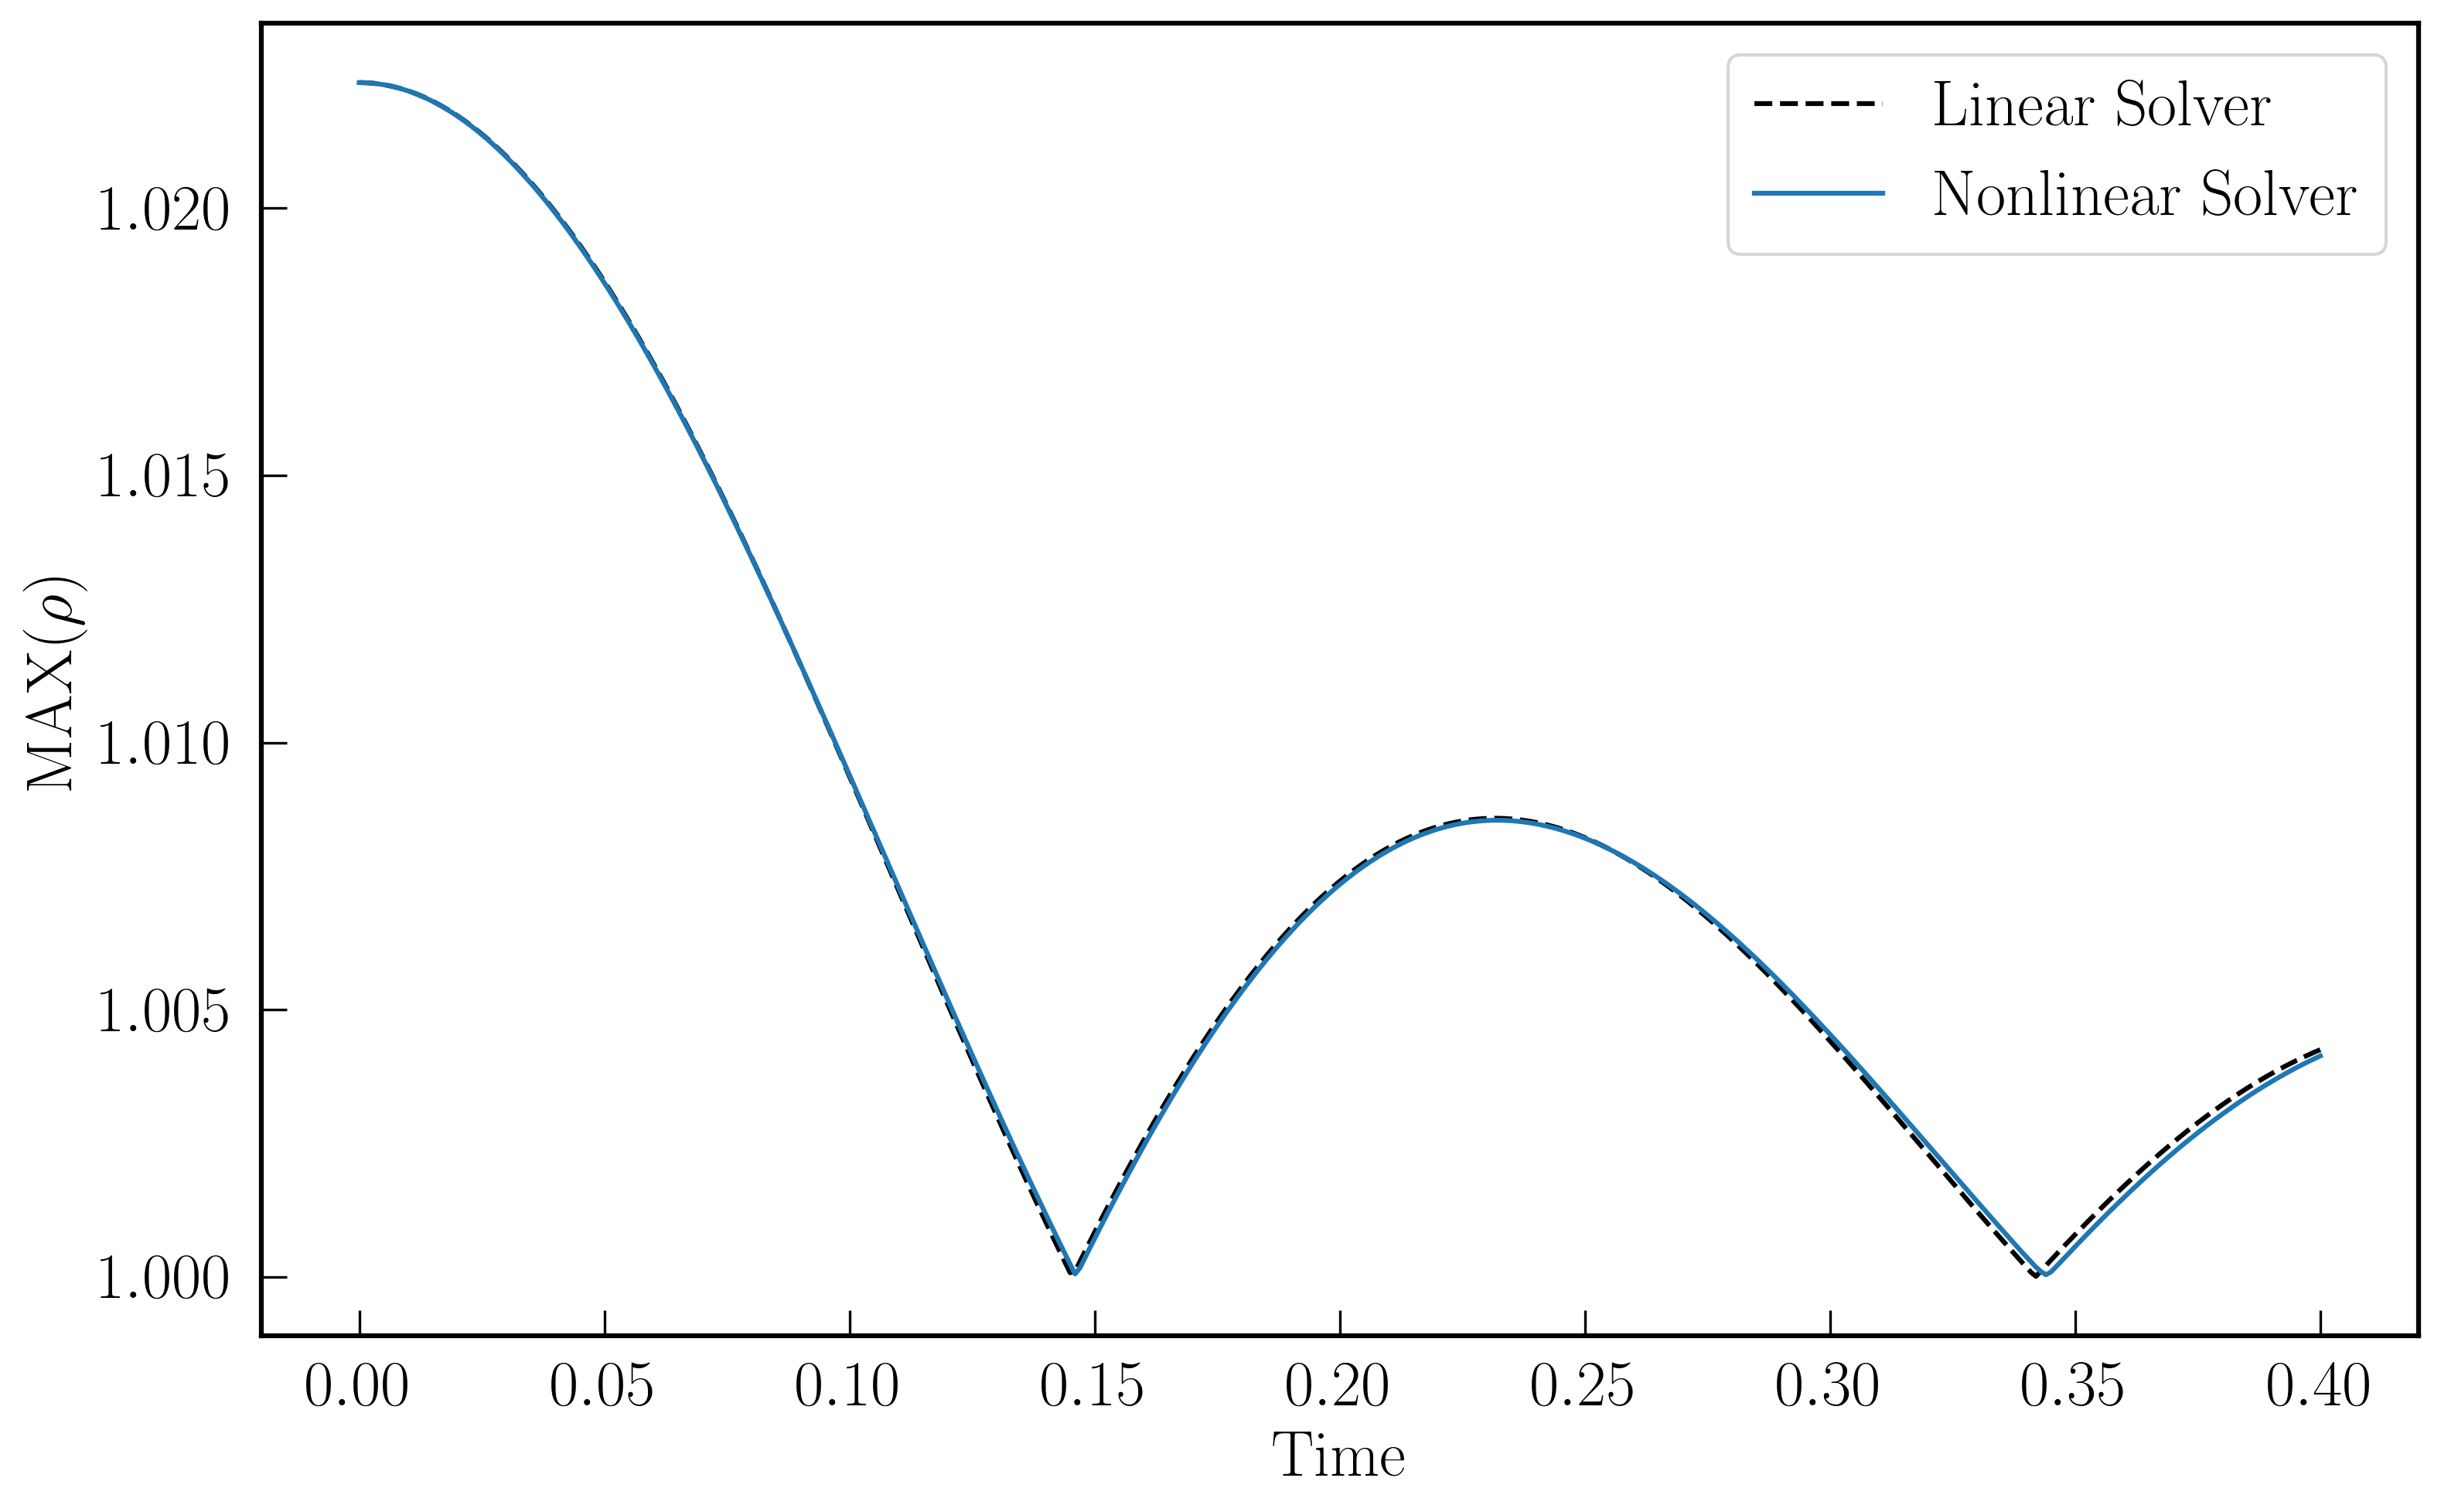

In [12]:
pl.plot(time_array, rho_data_ls, '--', color = 'black', label = 'Linear Solver')
pl.plot(time_array, rho_data_nls, label='Nonlinear Solver')
pl.ylabel(r'MAX($\rho$)')
pl.xlabel('Time')
pl.legend()